In [1]:
import pandapower.toolbox as tb
import pandapower as pp
import matplotlib.pyplot as plt
import pandapower.plotting as plot
from pandapower.plotting import simple_plot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from house_model.hv import HV_Model
from house_model.hv1 import HV1_Model
from house_model.uv2 import UV2_Model
from house_model.uv3 import UV3_Model
from house_model.uv4 import UV4_Model
from house_model.uv5 import UV5_Model
from house_model.uv6 import UV6_Model
from house_model.model import House_Model
from house_model.utils.modeling_methods import (
    create_std_types,
    create_bus,
    create_bus_and_connect,
    create_line
) 

In [2]:
def get_pp_network():
    #create empty net
    net = pp.create_empty_network() 


    
    navy_4x150_type = pp.load_std_type(net, "NAYY 4x150 SE", element='line')
    navy_4x150_type["r0_ohm_per_km"] = navy_4x150_type["r_ohm_per_km"]
    navy_4x150_type["c0_nf_per_km"] = navy_4x150_type["c_nf_per_km"]
    navy_4x150_type["x0_ohm_per_km"] = navy_4x150_type["x_ohm_per_km"]
    pp.create_std_type(net, navy_4x150_type, "navy_4x150_type")

    buses_lv = [[pp.create_bus(net, name=f"0{j}", vn_kv=0.4, type='n', geodata=(0,j)) for j in range (0, 5)]]
                   
    pp.create_ext_grid(net, bus=0, vm_pu = 1, name="Grid Connection", s_sc_max_mva=1000, s_sc_min_mva=0, rx_max=0.1, rx_min=0.1, x0x_max=0.1, rx0x_max=0.1, r0x0_max = 0.1)

    htype = "NA2XS2Y 1x240 RM/25 12/20 kV"
    line_length = 0.4  #km

    # line type vgl. 2018 Kochanneck p. 157
    ltype = "navy_4x150_type"
    line_length = 0.1  #km
    lines_400v = [[pp.create_line(net, from_bus=buses_lv[0][0], to_bus=buses_lv[0][1], length_km=line_length, name="Line",std_type=ltype)]]#pp.create_line(net, from_bus=buses_lv[0][0], to_bus=buses_lv[0][1], length_km=line_length, name="Line",std_type=ltype)]]
    lines_400v += [pp.create_line(net, from_bus=buses_lv[0][1], to_bus=buses_lv[0][2], length_km=line_length, name="Line",std_type=ltype)]
    lines_400v += [pp.create_line(net, from_bus=buses_lv[0][2], to_bus=buses_lv[0][3], length_km=line_length, name="Line",std_type=ltype)]
    lines_400v += [pp.create_line(net, from_bus=buses_lv[0][3], to_bus=buses_lv[0][4], length_km=line_length, name="Line",std_type=ltype)]
    
    return net, [], buses_lv, lines_400v

In [3]:
def plot_network(net, psize = 1, household_start_idx = 0):
    # Plot net
    
    lc = plot.plotly.create_line_trace(net,net.line.index, color='black',infofunc=net.line.std_type)
    tc = plot.plotly.create_trafo_trace(net, net.trafo.index, trafotype='2W',color='blue', infofunc=net.trafo.name, trace_name='trafos', cmin=None, cmax=None, cmap_vals=None,use_line_geodata=None)
    ext = plot.plotly.create_bus_trace(net, net.ext_grid.bus.values, patch_type="square", size=psize * 20, color="yellow")
    public_idx = net.bus.index[net.bus.index < household_start_idx]
    household_idx = net.bus.index[net.bus.index >= household_start_idx]
    bc = plot.plotly.create_bus_trace(net, public_idx, size=psize * 10, color="orange",infofunc=[','.join(x) for x in zip(map(str, public_idx), map(str, net.bus.name))])
    bc += plot.plotly.create_bus_trace(net, household_idx, size=psize * 2, color="green",infofunc=household_idx)
    if net.load is not None and len(net.load) == len(net.bus):
        bc = plot.plotly.create_bus_trace(net, public_idx, size=psize * 10, color="orange",infofunc=[','.join(x) for x in zip(map(str, net.bus.name), map(str, net.load.p_mw), map(str, net.res_bus.vm_pu))])
        bc += plot.plotly.create_bus_trace(net, household_idx, size=psize * 2, color="green",infofunc=[','.join(x) for x in zip(map(str, net.bus.name), map(str, net.load.p_mw), map(str, net.res_bus.vm_pu))])
        
    _ = plot.plotly.draw_traces(tc + lc + bc + ext, figsize=psize, aspectratio=(8,6))


In [6]:
def init_combined_network():
    return House_Model().net

### Combine and Merge Main Distributer with Sub-Distributers to pandapower Net

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


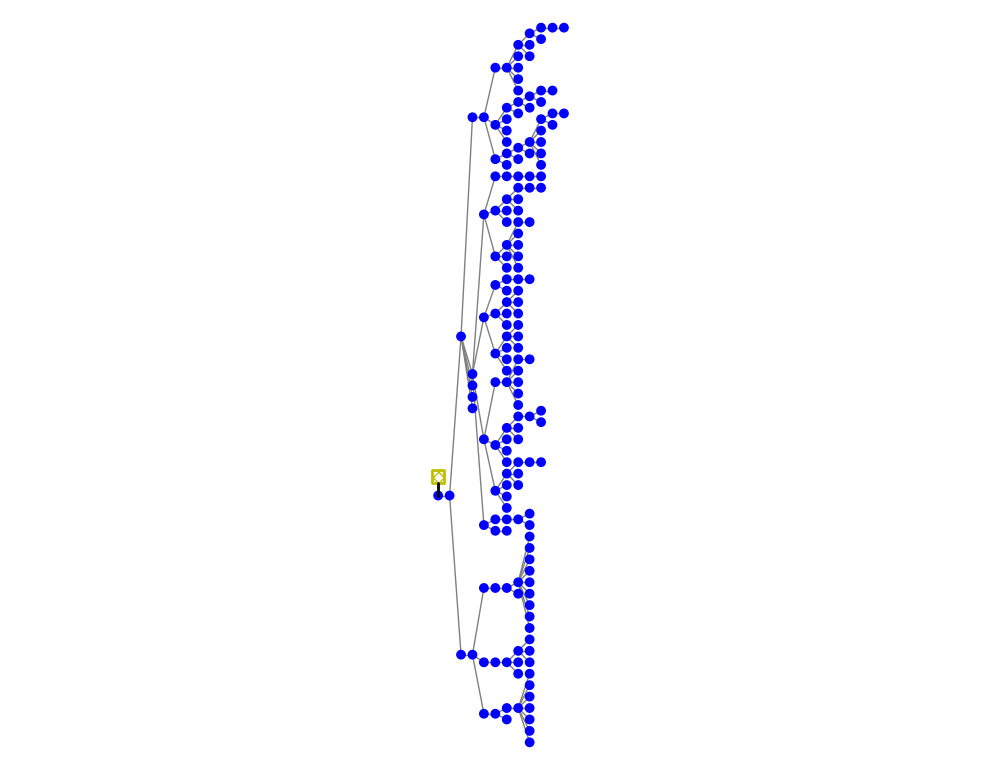

<Axes: >

In [7]:
def add_devices(combined_net):
    

    # the pandapower merge function requires an external grid for every net that should be merged. Delete them
    ext_grids = list(range(1, len(combined_net.ext_grid)))
    combined_net.ext_grid.drop(ext_grids, inplace=True)

    # find all indices with connections
    mask = [v[:12] == "ExternalGrid" and len(v) < 17 for v in combined_net.bus['name'].values]
    connections = combined_net.bus.index[mask]
    janitza1 = combined_net.bus.index[combined_net.bus['name'] == "Janitza 1 - Red Outlets"][0]
    janitza2 = combined_net.bus.index[combined_net.bus['name'] == "UV2, UV3, UV4, UV6"][0]
    janitza8 = combined_net.bus.index[combined_net.bus['name'] == "Janitza 8 - Kitchen"][0]

    for i in range(0, len(connections)): 
        from_bus = janitza2 # uv2, 3, 4, 6 are connected to Janitza2
        to_bus = connections[i]
        if i == 0: # hv1
            from_bus = janitza1 # red sockets are connected to Janitza 1
        elif i == 4: # uv5
            from_bus = janitza8 # kitchen is connected to Janitza 8
        length = 0.001
        uv_nr = combined_net.bus.iloc[to_bus]["name"][-1:]
        if uv_nr == "6":
            length = 0.02
        elif uv_nr == "5":
            length = 0.01
        elif uv_nr == "4":
            length = 0.01
        elif uv_nr == "3":
            length = 0.02
        elif uv_nr == "2":
            length = 0.005
        create_line(combined_net, from_bus, to_bus, 0.001, "NYM_J_5x6", "Coupling")

    return combined_net
    
combined_net = init_combined_network()
combined_net = add_devices(combined_net)
simple_plot(combined_net)

### Plot Different Sub-Distributers in Different Colors Using Collections

use_bus_geodata is automatically set to True, since net.line_geodata is empty.


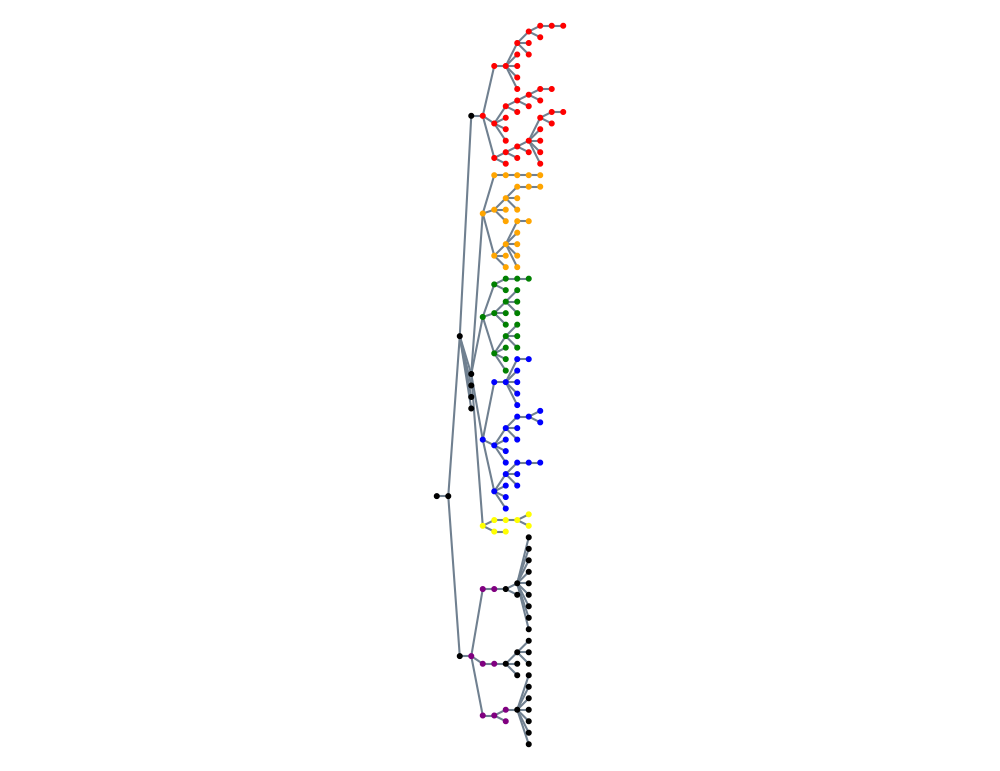

In [8]:
# Returns a line collection
def add_connections(combined_net):

    connections = combined_net.bus.index[[v[:12] == "ExternalGrid" and len(v) < 17 for v in combined_net.bus['name'].values]]
    # different colors for different sub-distributers
    colors= ['black', 'purple', 'yellow', 'blue', 'green', 'red', 'orange']
    # line collection
    lc = plot.create_line_collection(combined_net, color='slategrey', zorder=0)
    # all collections
    bcs = [lc]

    first_idx = 0
    for i in range(0, len(connections) + 1):
        if (i == len(connections)):
            last_idx = len(combined_net.bus)
        else:
            last_idx = connections[i]
        # a new bus collections for every sub-distributer
        bcs.append(plot.create_bus_collection(combined_net, buses=range(first_idx, last_idx), color=colors[i], zorder=1, size=0.2))
        first_idx = last_idx  

    return bcs
    
bcs = add_connections(combined_net)
plot.draw_collections(bcs)
plt.show()

In [9]:
geodata_template = combined_net.bus_geodata.copy()
geodata_template *= 0.03
geodata_template.y *= 0.9
geodata_template.x *= 2

In [10]:
net, _, _, _ = get_pp_network()
n_connections = [0 for _ in range(0, len(net.bus))]
#n_connections
for line in net.line.iloc:
    n_connections[line.from_bus] += 1
    n_connections[line.to_bus] += 1
for to_bus in range(1, len(n_connections)):
    house_net = init_combined_network()
    house_net = add_devices(house_net)
    net = tb.merge_nets(net, house_net)
    pub_bus = net.bus.index[net.bus['name'] == "ExternalGrid Public Grid"][0]
    # Create public connection
    create_line(net, pub_bus, to_bus, 0.03, "NYM_J_5x6", "Coupling")

    # Rename public bus
    indx_0 = net.bus.index[net.bus['name'] == "ExternalGrid Public Grid"][0]
    net.bus.at[indx_0, "name"] = "Public"
    
    # the pandapower merge function requires an external grid for every net that should be merged. Delete them
    ext_grids = list(range(1, len(net.ext_grid)))
    net.ext_grid.drop(ext_grids, inplace=True)
    geodata_template.x *= -1
    # Insert geodata coordinates
    net.bus_geodata = net.bus_geodata.append(geodata_template + net.bus_geodata.iloc[to_bus])
    # Correct indices
    net.bus_geodata.index = range(0, len(net.bus_geodata))

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
plot_network(net, psize = 1, household_start_idx=1)